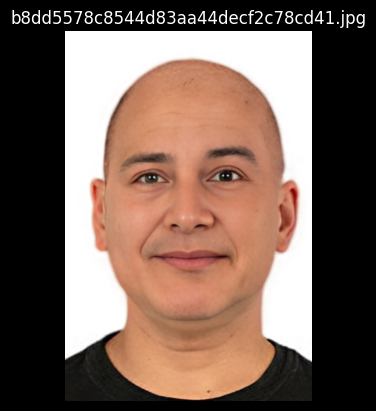

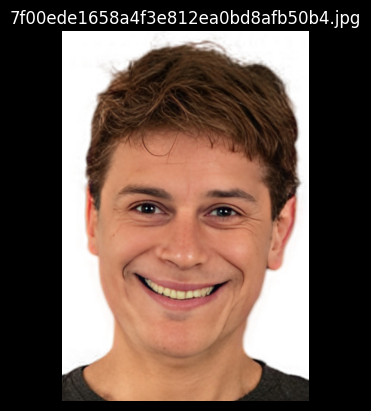

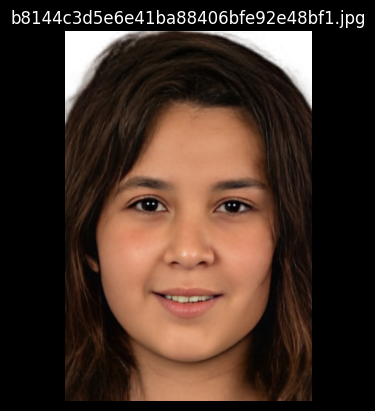

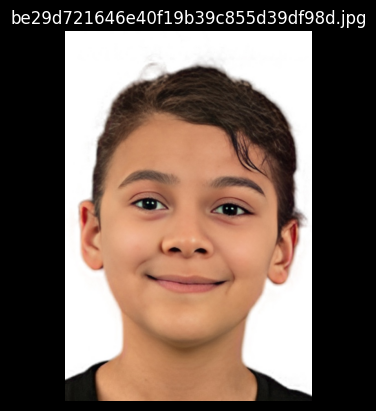

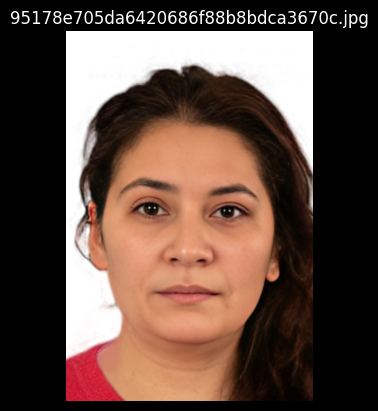

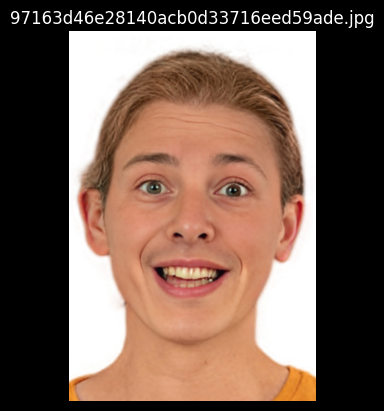

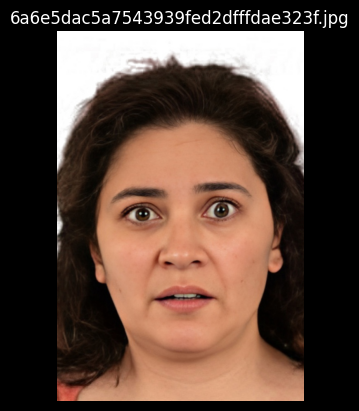

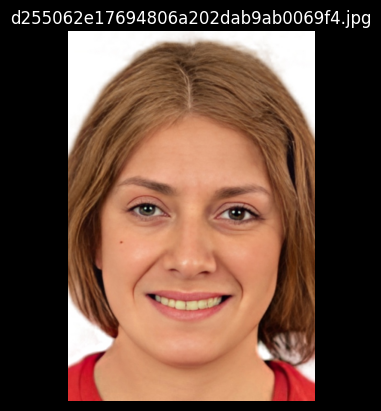

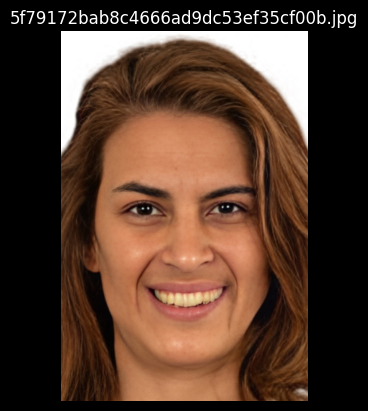

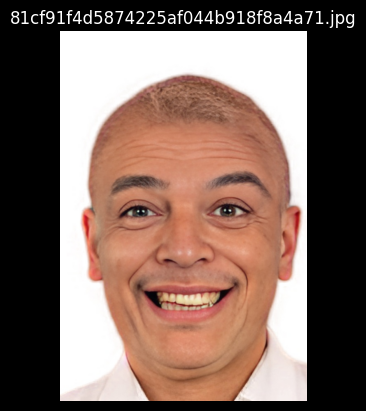

In [21]:
import matplotlib.pyplot as plt
import os

from PIL import Image

image_folder = "fixtures/synt-humans-processed"

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    img = Image.open(image_path)
    img = img.convert("RGB")

    plt.imshow(img)
    plt.axis("off")
    plt.title(image_name)
    plt.show()


In [22]:
from typing import List, Dict
import os
from PIL import Image
from blockiness import calculate_image_blockiness, rgb_to_grayscale
import torchvision

MIN_RESOLUTION = 600  # minimum pixel size
ASPECT_RATIO_TARGET = 1.5  # 3/2 ratio
ASPECT_RATIO_TOLERANCE = 0.05  # tolerance +-5%
SUPPORTED_FORMATS = ['JPEG', 'PNG']
JPEG_BLOCKINESS_THRESHOLD = 40  # Heuristic threshold for JPEG blockiness (can be adjusted)

def get_image_info(image_path: str) -> Dict[str, int]:
    """
    Decodes the image and retrieves width, height, channels, and format.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - dict: A dictionary containing 'width', 'height', 'channels', 'format'.
    """
    try:
        with Image.open(image_path) as image:
            width, height = image.size
            channels = len(image.getbands())  # RGB = 3 channels, RGBA = 4 channels, etc.
            format_ = image.format  # e.g., JPEG, PNG

        return {
            'width': width,
            'height': height,
            'channels': channels,
            'format': format_
        }

    except Exception as e:
        raise ValueError(f"Error opening image: {e}")


def check_aspect_ratio(width: int, height: int) -> bool:
    """
    Checks if the aspect ratio is close to 3/2 with a tolerance.

    Args:
    - width (int): Width of the image.
    - height (int): Height of the image.

    Returns:
    - bool: True if aspect ratio is within the tolerance, False otherwise.
    """
    ratio = max(width, height) / min(width, height)
    return abs(ratio - ASPECT_RATIO_TARGET) <= ASPECT_RATIO_TARGET * ASPECT_RATIO_TOLERANCE


def check_resolution(width: int, height: int) -> bool:
    """
    Checks if the resolution (min dimension) is above the required threshold.

    Args:
    - width (int): Width of the image.
    - height (int): Height of the image.

    Returns:
    - bool: True if resolution is sufficient, False otherwise.
    """
    return min(width, height) >= MIN_RESOLUTION


def check_file_format_and_bit_depth(format_: str, channels: int) -> bool:
    """
    Checks if the image file format and bit depth are supported.

    Args:
    - format_ (str): Image format (e.g., JPEG, PNG).
    - channels (int): Number of channels in the image.

    Returns:
    - bool: True if format and bit depth are valid, False otherwise.
    """
    if format_ not in SUPPORTED_FORMATS:
        return False  # Unsupported format (e.g., GIF, BMP)

    # JPEG and PNG must be RGB (3 channels)
    return format_ == 'JPEG' and channels == 3 or format_ == 'PNG' and channels == 3


def check_jpeg_quality(image_path: str) -> bool:
    """
    Check the quality of a JPEG image using the blockiness metric.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - bool: True if the image quality is acceptable, False otherwise.
    """
    if not image_path.lower().endswith(('.jpeg', '.jpg')):
        return True  # Only check JPEG quality for JPEG images.

    try:
        # Read the image as a tensor (with channels first: CxHxW)
        img = torchvision.io.read_image(image_path)

        # Convert the image to grayscale (if it's not already in grayscale)
        img_gray = rgb_to_grayscale(img.unsqueeze(0))  # Add batch dimension (B, C, H, W)

        # Compute blockiness using the correct function
        blockiness_score = calculate_image_blockiness(img_gray)  # (B, 1, H, W) shape is required

        return blockiness_score.item() <= JPEG_BLOCKINESS_THRESHOLD  # True if blockiness is low enough
    except Exception as e:
        raise ValueError(f"Error checking JPEG quality: {e}")


def validate_image(image_path: str) -> List[str]:
    """
    Validate the image according to all the checks and return a list of errors.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - list: A list of error strings (if any).
    """
    errors = []

    # Get image information
    try:
        image_info = get_image_info(image_path)
        width = image_info['width']
        height = image_info['height']
        channels = image_info['channels']
        format_ = image_info['format']
    except ValueError as e:
        return [str(e)]

    # Check aspect ratio
    if not check_aspect_ratio(width, height):
        errors.append("Wrong aspect ratio")

    # Check resolution
    if not check_resolution(width, height):
        errors.append("Resolution too low")

    # Check file format and bit depth
    if not check_file_format_and_bit_depth(format_, channels):
        errors.append("Unsupported file format")

    # Check JPEG quality (if applicable)
    if format_ == 'JPEG' and not check_jpeg_quality(image_path):
        errors.append("Low quality / too compressed")

    return errors


def process_images_in_folder(image_folder: str):
    """
    Processes all images in the given folder, validating each image.

    Args:
    - image_folder (str): Path to the folder containing images.
    """
    for image_name in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_name)

        # Validate the image
        errors = validate_image(image_path)

        if errors:
            print(f"Image: {image_name} - Errors: {', '.join(errors)}")
        else:
            print(f"Image: {image_name} - No errors found.")

In [23]:
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    errors = validate_image(image_path)
    if errors:
        print(f"Image: {image_name} - Errors: {', '.join(errors)}")
    else:
        print(f"Image: {image_name} - No errors found.")

Image: b8dd5578c8544d83aa44decf2c78cd41.jpg - No errors found.
Image: 7f00ede1658a4f3e812ea0bd8afb50b4.jpg - No errors found.
Image: b8144c3d5e6e41ba88406bfe92e48bf1.jpg - No errors found.
Image: be29d721646e40f19b39c855d39df98d.jpg - No errors found.
Image: 95178e705da6420686f88b8bdca3670c.jpg - No errors found.
Image: 97163d46e28140acb0d33716eed59ade.jpg - No errors found.
Image: 6a6e5dac5a7543939fed2dfffdae323f.jpg - No errors found.
Image: d255062e17694806a202dab9ab0069f4.jpg - No errors found.
Image: 5f79172bab8c4666ad9dc53ef35cf00b.jpg - No errors found.
Image: 81cf91f4d5874225af044b918f8a4a71.jpg - No errors found.


In [24]:
# iterate through images in nested folders and validate them
# save statistics about errors found

image_folder = "fixtures/FLUXSynID-processed"
error_statistics = {}  # Dictionary to hold error statistics

IMG_COUNT = 1000
iter = 0

for identity_name in os.listdir(image_folder):
    if iter >= IMG_COUNT:
        break

    identity_folder = os.path.join(image_folder, identity_name)
    for image_name in os.listdir(identity_folder):
        # check if it's jpeg
        if not image_name.endswith(".jpg"):
            continue

        iter += 1

        image_path = os.path.join(identity_folder, image_name)

        errors = validate_image(image_path)
        if errors:
            error_statistics[f"{identity_name}/{image_name}"] = errors
        else:
            error_statistics[f"{identity_name}/{image_name}"] = ["No errors found."]

# Print error statistics about the images
# conveniently grouped by error type
from collections import defaultdict
grouped_errors = defaultdict(list)

for image, errors in error_statistics.items():
    for error in errors:
        grouped_errors[error].append(image)

# Print the grouped error statistics
# for error_type, images in grouped_errors.items():
#     print(f"Error Type: {error_type}")
#     for image in images:
#         print(f" - {image}")

# print number of each type of the error
for error_type, images in grouped_errors.items():
    print("Error Type: ", error_type, " count: ", len(images))

Error Type:  No errors found.  count:  247
Error Type:  Low quality / too compressed  count:  5
